In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, mean_squared_error
import pickle
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from itertools import combinations
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_rating = pd.read_csv('/content/drive/MyDrive/Books/Ratings.csv')
df_books = pd.read_csv('/content/drive/MyDrive/Books/Books.csv')
df_users = pd.read_csv('/content/drive/MyDrive/Books/Users.csv')
df_images = df_books.iloc[:, -2:]
df_books = df_books.iloc[:, :-2]
userCounts = df_rating['User-ID'].value_counts()
isbnCounts = df_rating['ISBN'].value_counts()
dfr = df_rating
dfr = dfr[~dfr['ISBN'].isin(isbnCounts[isbnCounts < 100].index)]

dfr = pd.merge(right=dfr, left = df_books, on="ISBN")
dfr.head()
dfr = dfr[~dfr['User-ID'].isin(userCounts[userCounts < 200].index)]
dfr = dfr.drop_duplicates(["Book-Title", "User-ID"])
combine_book_rating = dfr
columns = ['Year-Of-Publication', 'Book-Author', 'Image-URL-S', 'Publisher']
combine_book_rating =  combine_book_rating.drop(columns, axis=1)
df_for_nn = combine_book_rating
combine_book_rating.shape[0]
unique_books = df_for_nn['Book-Title'].unique()
book_id_mapping = {book_title: book_id for book_id, book_title in enumerate(unique_books, start=1)}

df_for_nn['Book-ID'] = df_for_nn['Book-Title'].map(book_id_mapping)
train, test = train_test_split(df_for_nn, test_size=0.2, random_state=42)

# For neural network
with open('/content/drive/MyDrive/Neural Network/model(Final)', 'rb') as file:
    model_for_nn = pickle.load(file)
predicted_ratings = model_for_nn.predict([test['User-ID'], test['Book-ID']])

predicted_ratings_discrete = np.round(predicted_ratings).astype(int)

actual_ratings_discrete = test['Book-Rating'].values.astype(int)
precision = precision_score(actual_ratings_discrete, predicted_ratings_discrete, average='weighted')

print("Precision:", precision)

<ipython-input-3-8ac1f0f21f68>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('/content/drive/MyDrive/Books/Books.csv')


308/308 [==============================] - 1s 2ms/step
Precision: 0.7079287259489724


In [4]:
# Matrix Factorization
book_pivot_test = test.pivot_table(columns='User-ID', index='Book-Title', values='Book-Rating')
book_pivot_test.fillna(0,inplace=True)
Trans = book_pivot_test
SVD = TruncatedSVD(n_components=20, random_state=10)
matrix = SVD.fit_transform(Trans)
corr = np.corrcoef(matrix)

def get_recommend_MF_test(name):
    """The function to get recommendations"""
    book_title = book_pivot_test.T.columns
    book_list = list(book_title)
    book_index = book_list.index(name)
    corr_book = corr[book_index]

    correlated_books = list(book_title[corr_book > 0.8])[:7]
    if name in correlated_books:
     correlated_books.remove(name)
    correlated_books.insert(0, name)

    if len(correlated_books) > 7:
        correlated_books.pop()

    return correlated_books

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [5]:
get_recommend_MF_test("The Catcher in the Rye")

['The Catcher in the Rye',
 'A Walk in the Woods: Rediscovering America on the Appalachian Trail (Official Guides to the Appalachian Trail)',
 "Don't Stand Too Close to a Naked Man",
 'Tara Road',
 'The Curious Incident of the Dog in the Night-Time (Today Show Book Club #13)',
 "The Hitchhiker's Guide to the Galaxy",
 'Three To Get Deadly : A Stephanie Plum Novel (A Stephanie Plum Novel)']

In [6]:
# Jaccard Similarity
pt = book_pivot_test
def jaccard_similarity(user1_interactions, user2_interactions):
    # Compute Jaccard similarity between two sets of interactions
    intersection = len(set(user1_interactions) & set(user2_interactions))
    union = len(set(user1_interactions) | set(user2_interactions))
    if union == 0:
        return 0  # Handle division by zero
    return intersection / union

def compute_user_similarity_matrix(pt):
    users = pt.columns.tolist()
    user_similarity_matrix = pd.DataFrame(index=users, columns=users)
    for user1, user2 in combinations(users, 2):
        similarity = jaccard_similarity(pt[user1][pt[user1] > 0].index, pt[user2][pt[user2] > 0].index)
        user_similarity_matrix.loc[user1, user2] = similarity
        user_similarity_matrix.loc[user2, user1] = similarity
    return user_similarity_matrix

# Compute user-user similarity matrix using Jaccard similarity
user_similarity_matrix = compute_user_similarity_matrix(pt)

In [7]:
# Sort the user-user similarity matrix by similarity values in descending order
sorted_user_similarity_matrix = user_similarity_matrix.sort_values(by=user_similarity_matrix.columns.tolist(), ascending=False)
def get_recommend_JS_test(book_name):
    global pt
    global user_similarity_matrix

    # Check if the book name exists in the interaction matrix
    if book_name not in pt.index:
        print(f"Book '{book_name}' not found in the interaction matrix.")
        return []

    # Get interactions for the input book
    book_interactions = pt.loc[book_name]

    # Find users who have interacted with the input book
    interacting_users = book_interactions[book_interactions > 0].index.tolist()

    # Aggregate similarities for interacting users
    user_similarities = user_similarity_matrix.loc[interacting_users].sum()

    # Sort users by aggregated similarity
    most_similar_users = user_similarities.sort_values(ascending=False).index.tolist()

    # Get books interacted with by the most similar users
    recommended_books = []
    for user in most_similar_users:
        user_interactions = pt[user]
        user_books = user_interactions[user_interactions > 0].index.tolist()
        recommended_books.extend(user_books)

    # Remove books already interacted with by the target user
    recommended_books = [book for book in recommended_books if book not in pt.loc[book_name][pt.loc[book_name] > 0].index.tolist()]

    # Remove duplicates while preserving order
    recommended_books = list(dict.fromkeys(recommended_books))

    return recommended_books[:8]

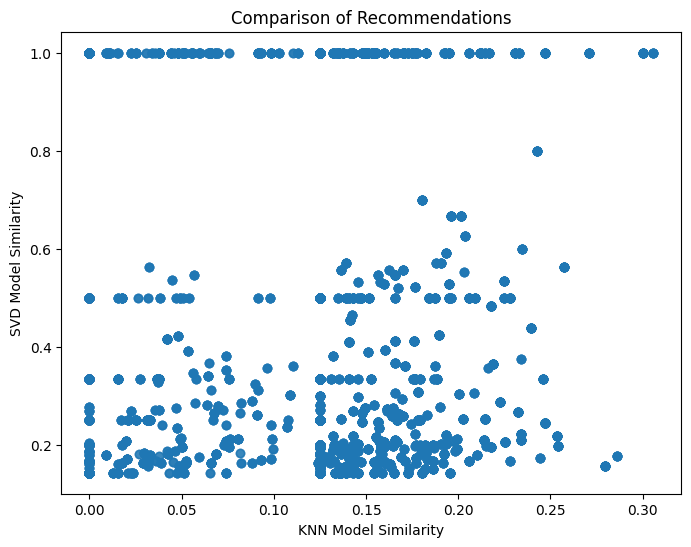

In [8]:
js_sim = []
svd_sim = []
def calculate_string_similarity(title1, title2):
    title1_set = set(title1.lower().split())
    title2_set = set(title2.lower().split())

    intersection = len(title1_set.intersection(title2_set))
    union = len(title1_set.union(title2_set))

    similarity = intersection / union if union != 0 else 0

    return similarity

def calculate_similarity(original_book, recommended_books):

    similarities = []
    for recommended_book in recommended_books:
        # Calculate similarity using a simple string similarity metric (e.g., Jaccard similarity)
        similarity = calculate_string_similarity(original_book, recommended_book)
        similarities.append(similarity)

    # Average similarity across all recommended books
    avg_similarity = sum(similarities) / len(similarities)

    return avg_similarity
    pass

def compare_recommendations(test_data):
    js_similarities = []
    svd_similarities = []

    for book in test_data:
        js_recommendations = get_recommend_JS_test(book)
        svd_recommendations = get_recommend_MF_test(book)

        # Calculate similarity/difference metric
        knn_similarity = calculate_similarity(book, js_recommendations)
        svd_similarity = calculate_similarity(book, svd_recommendations)

        js_similarities.append(knn_similarity)
        js_sim.append(knn_similarity)
        svd_similarities.append(svd_similarity)
        svd_sim.append(svd_similarity)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(js_similarities, svd_similarities, alpha=0.5)
    plt.xlabel('KNN Model Similarity')
    plt.ylabel('SVD Model Similarity')
    plt.title('Comparison of Recommendations')
    plt.show()


compare_recommendations(test['Book-Title'])

In [9]:
with open('/content/drive/MyDrive/Colab Notebooks/svd_sim', 'wb') as file:
    pickle.dump(svd_sim, file)
with open('/content/drive/MyDrive/Colab Notebooks/js_sim', 'wb') as file:
    pickle.dump(js_sim, file)

In [10]:
def get_confusion_matrix(js_similarities, svd_similarities, threshold):
    js_predictions = np.array([1 if similarity >= threshold else 0 for similarity in js_similarities])
    svd_predictions = np.array([1 if similarity >= threshold else 0 for similarity in svd_similarities])

    # Calculate confusion matrix
    tp = np.sum(np.logical_and(js_predictions == 1, svd_predictions == 1))
    fp = np.sum(np.logical_and(js_predictions == 0, svd_predictions == 1))
    fn = np.sum(np.logical_and(js_predictions == 1, svd_predictions == 0))
    tn = np.sum(np.logical_and(js_predictions == 0, svd_predictions == 0))

    confusion_matrix = np.array([[tp, fp], [fn, tn]])

    return confusion_matrix

confusion_matrix = get_confusion_matrix(js_sim, svd_sim, threshold=0.15)
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[3321 4921]
 [ 131 1455]]


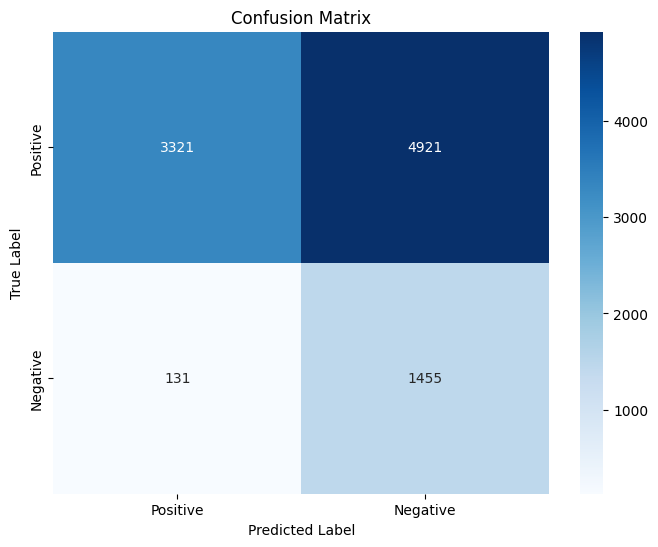

In [14]:
# Visualizing confusion matrix
confusion_matrix = np.array([[3321, 4921], [131, 1455]])
class_labels = ["Positive", "Negative"]
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
tp, fp = confusion_matrix[0]  # True Positives, False Positives
fn, tn = confusion_matrix[1]  # False Negatives, True Negatives

# Precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0

# Recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

# F1-score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.4029361805387042
Recall: 0.9620509849362688
F1-score: 0.5679835813237558
